In [68]:
import copy
import os
import time
import warnings

import aprofiles as apro
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

In [69]:
## Work on A-Profiles

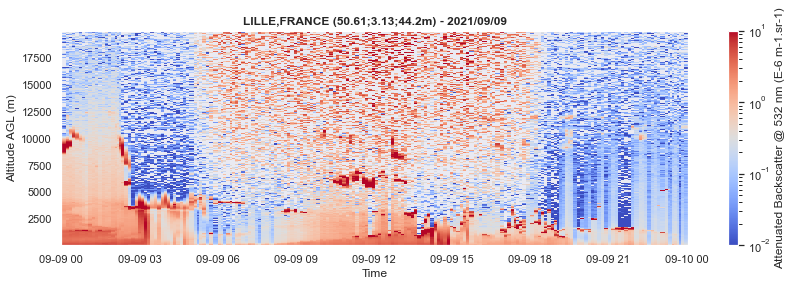

In [110]:
#path = "examples/data/E-PROFILE/L2_0-20000-001492_A20210909.nc"
#path = "data/e-profile/2021/09/09/L2_0-20000-001492_A20210909.nc"
#path = "data/e-profile/2021/09/09/L2_0-20008-0BRC_A20210909.nc" # Barcelona
#path = "data/e-profile/2021/09/10/L2_0-20008-0INO_A20210910.nc" # Magurele Rado
#path = "data/e-profile/2021/09/09/L2_0-20008-0INO_B20210909.nc" # ?
path = "data/e-profile/2021/09/09/L2_0-20000-007014_A20210909.nc" # Lille
#path = "data/e-profile/2021/09/09/L2_0-20000-007606_A20210909.nc" # Momuy

apro_reader = apro.reader.ReadProfiles(path)
profiles = apro_reader.read()

# extrapolation lowest layers
profiles.extrapolate_below(z=150, inplace=True)

# detection
#profiles.foc(zmin_cloud=250)
#profiles.clouds(zmin=250, thr_noise=5, thr_clouds=4, verbose=True)
#profiles.pbl(zmin=200, zmax=3000, under_clouds=False, min_snr=1., verbose=True)

# plot image
#profiles.plot(zref='agl', show_foc=True, show_clouds=True, show_pbl=True, log=True, vmin=1e-2, vmax=1e1)
profiles.plot(zref='agl', show_foc=False, show_clouds=False, show_pbl=False, log=True, vmin=1e-2, vmax=1e1)


klett : 100%|██████████| 194/194 [00:03<00:00, 54.79it/s]


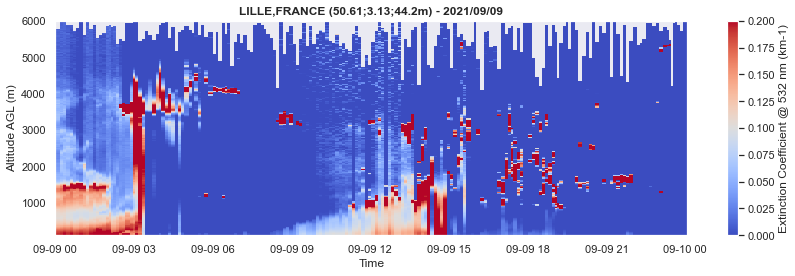

In [113]:
profiles.inversion(zmin=4000., zmax=6000., remove_outliers=False, method="forward", verbose=True)
# plot extinction profiles
profiles.plot(var="extinction", zmax=6000, vmin=0, vmax=0.2)
#datetime = np.datetime64('2021-09-09T22:00:00')
#profiles.plot(var="extinction", datetime = datetime, zmax=6000, vmin=-0.1, zmin=0)

klett : 100%|██████████| 193/193 [00:00<00:00, 331.67it/s]


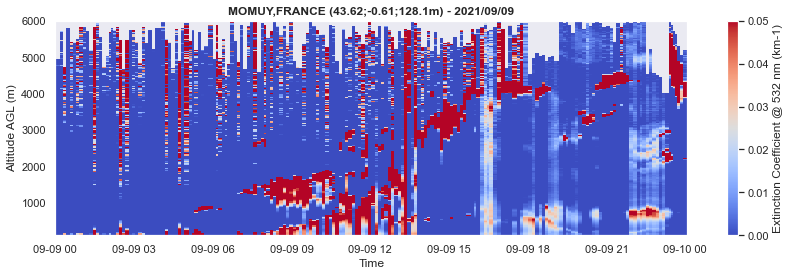

In [83]:
profiles.inversion(zmin=4000., zmax=6000., remove_outliers=False, method="backward", verbose=True)
# plot extinction profiles
profiles.plot(var="extinction", zmax=6000, vmin=0, vmax=5e-2)

In [48]:
## Work on A-Profiles output

In [49]:
BASE_DIR_OUT = "data/v-profiles"
date = "2021-09-09"
yyyy = date.split("-")[0]
mm = date.split("-")[1]
dd = date.split("-")[2]


In [50]:
datepath = os.path.join(BASE_DIR_OUT, yyyy, mm, dd)
onlyfiles = [f for f in os.listdir(datepath) if os.path.isfile(os.path.join(datepath, f))]

In [51]:
matching_index = [i for i, s in enumerate(onlyfiles) if "0-20000-0-01492" in s][0]

In [52]:
filename = onlyfiles[matching_index]
ds = xr.open_dataset(os.path.join(datepath, filename), decode_times=True)
ds

<xarray.Dataset>
Dimensions:                   (aer_type: 4, altitude: 511, time: 273)
Coordinates:
  * time                      (time) int64 1631145604000 ... 1631231706000
  * altitude                  (altitude) float64 111.0 141.0 ... 1.541e+04
  * aer_type                  (aer_type) object 'dust' ... 'urban'
Data variables: (12/19)
    start_time                (time) datetime64[ns] ...
    latitude                  (time, altitude) float64 ...
    longitude                 (time, altitude) float64 ...
    attenuated_backscatter_0  (time, altitude) float64 ...
    quality_flag              (time, altitude) int64 ...
    cloud_amount              (time) float64 ...
    ...                        ...
    aod                       (time) float64 ...
    lidar_ratio               (time) float64 ...
    z_ref                     (time) float64 ...
    emc                       (aer_type) float64 ...
    scene                     (time) object ...
    retrieval_scene           (time) object ...
Attributes: (12/24)
    instrument_id:                A
    hermes_history:               hermes-raw2l1 2.0.1, hermes-eprofile-alc-sc...
    instrument_type:              CHM15k
    site_location:                OSLO,NORWAY
    title:                        OSLO nimbus MET NORWAY
    principal_investigator:       Remote Sensing Group
    ...                           ...
    history:                      Thu Sep  9 00:30:28 2021: ncpdq -O -a time,...
    NCO:                          netCDF Operators version 4.9.1 (Homepage = ...
    l0_wavelength:                1064.0
    station_latitude:             59.94200134277344
    station_longitude:            10.720000267028809
    station_altitude:             96.0

In [53]:
ds.retrieval_scene

<xarray.DataArray 'retrieval_scene' (time: 273)>
array(['foc', 'cloud_above', 'cloud_below', ..., 'foc', 'foc', 'foc'],
      dtype=object)
Coordinates:
  * time     (time) int64 1631145604000 1631145904000 ... 1631231706000
Attributes:
    long_name:   Retrieval scene classification
    definition:  cloud_above: cloud above reference altitude - cloud_below: c...

In [54]:
def convert_time_int_to_datetime(ds):
    time_data = [time*1e6 for time in ds.time.data]
    time_attrs = ds["time"].attrs
    ds = ds.assign_coords(time=(pd.to_datetime(time_data)))
    ds["time"] = ds["time"].assign_attrs(time_attrs)
    ds["time"].attrs['units'] = 'datetime'
    return ds

In [55]:
def convert_time_datetime_to_int(ds):
    time_attrs = ds["time"].attrs
    ds = ds.assign_coords(time=ds.time.data.astype(f"datetime64[ms]").astype(int))
    ds["time"] = ds["time"].assign_attrs(time_attrs)
    ds["time"].attrs['units'] = 'milliseconds after epoch'
    return ds

In [56]:
# converts time
ds = convert_time_int_to_datetime(ds)
ds

<xarray.Dataset>
Dimensions:                   (aer_type: 4, altitude: 511, time: 273)
Coordinates:
  * time                      (time) datetime64[ns] 2021-09-09T00:00:04 ... 2...
  * altitude                  (altitude) float64 111.0 141.0 ... 1.541e+04
  * aer_type                  (aer_type) object 'dust' ... 'urban'
Data variables: (12/19)
    start_time                (time) datetime64[ns] 2021-09-08T23:55:04 ... 2...
    latitude                  (time, altitude) float64 ...
    longitude                 (time, altitude) float64 ...
    attenuated_backscatter_0  (time, altitude) float64 ...
    quality_flag              (time, altitude) int64 ...
    cloud_amount              (time) float64 4.0 2.0 1.0 1.0 ... 8.0 8.0 8.0 8.0
    ...                        ...
    aod                       (time) float64 0.2175 0.1596 ... 0.1678 0.3514
    lidar_ratio               (time) float64 50.0 50.0 50.0 ... 50.0 50.0 50.0
    z_ref                     (time) float64 5.331e+03 5.661e+03 ... 4.911e+03
    emc                       (aer_type) float64 0.3831 0.6828 0.6815 0.3066
    scene                     (time) object 'foc' 'mid_cloud' ... 'foc' 'foc'
    retrieval_scene           (time) object 'foc' 'cloud_above' ... 'foc' 'foc'
Attributes: (12/24)
    instrument_id:                A
    hermes_history:               hermes-raw2l1 2.0.1, hermes-eprofile-alc-sc...
    instrument_type:              CHM15k
    site_location:                OSLO,NORWAY
    title:                        OSLO nimbus MET NORWAY
    principal_investigator:       Remote Sensing Group
    ...                           ...
    history:                      Thu Sep  9 00:30:28 2021: ncpdq -O -a time,...
    NCO:                          netCDF Operators version 4.9.1 (Homepage = ...
    l0_wavelength:                1064.0
    station_latitude:             59.94200134277344
    station_longitude:            10.720000267028809
    station_altitude:             96.0

In [57]:
ds = ds.resample(time='1H').mean()
ds

<xarray.Dataset>
Dimensions:                   (aer_type: 4, altitude: 511, time: 24)
Coordinates:
  * time                      (time) datetime64[ns] 2021-09-09 ... 2021-09-09...
  * altitude                  (altitude) float64 111.0 141.0 ... 1.541e+04
  * aer_type                  (aer_type) object 'dust' ... 'urban'
Data variables: (12/16)
    latitude                  (time, altitude) float64 nan nan nan ... nan nan
    longitude                 (time, altitude) float64 nan nan nan ... nan nan
    attenuated_backscatter_0  (time, altitude) float64 89.12 89.12 ... 0.009242
    quality_flag              (time, altitude) float64 0.0 0.0 0.0 ... 1.0 1.0
    cloud_amount              (time) float64 4.333 8.167 8.333 ... 4.25 7.25 8.0
    calibration_constant_0    (time) float64 4.239e+11 4.239e+11 ... 4.239e+11
    ...                        ...
    pbl                       (time) float64 nan nan nan nan ... 898.5 501.0 nan
    extinction                (time, altitude) float64 0.8234 0.8236 ... nan nan
    aod                       (time) float64 0.1866 0.0247 ... 0.09594 0.2744
    lidar_ratio               (time) float64 50.0 50.0 50.0 ... 50.0 50.0 50.0
    z_ref                     (time) float64 5.578e+03 5.563e+03 ... 5.276e+03
    emc                       (time, aer_type) float64 0.3831 0.6828 ... 0.3066

In [60]:
ds = convert_time_datetime_to_int(ds)
ds

<xarray.Dataset>
Dimensions:                   (aer_type: 4, altitude: 511, time: 24)
Coordinates:
  * time                      (time) int64 1631145600000 ... 1631228400000
  * altitude                  (altitude) float64 111.0 141.0 ... 1.541e+04
  * aer_type                  (aer_type) object 'dust' ... 'urban'
Data variables: (12/16)
    latitude                  (time, altitude) float64 nan nan nan ... nan nan
    longitude                 (time, altitude) float64 nan nan nan ... nan nan
    attenuated_backscatter_0  (time, altitude) float64 89.12 89.12 ... 0.009242
    quality_flag              (time, altitude) float64 0.0 0.0 0.0 ... 1.0 1.0
    cloud_amount              (time) float64 4.333 8.167 8.333 ... 4.25 7.25 8.0
    calibration_constant_0    (time) float64 4.239e+11 4.239e+11 ... 4.239e+11
    ...                        ...
    pbl                       (time) float64 nan nan nan nan ... 898.5 501.0 nan
    extinction                (time, altitude) float64 0.8234 0.8236 ... nan nan
    aod                       (time) float64 0.1866 0.0247 ... 0.09594 0.2744
    lidar_ratio               (time) float64 50.0 50.0 50.0 ... 50.0 50.0 50.0
    z_ref                     (time) float64 5.578e+03 5.563e+03 ... 5.276e+03
    emc                       (time, aer_type) float64 0.3831 0.6828 ... 0.3066

In [61]:
ds.extinction

<xarray.DataArray 'extinction' (time: 24, altitude: 511)>
array([[0.823429  , 0.82359077, 0.82375207, ...,        nan,        nan,
               nan],
       [0.23305512, 0.23311136, 0.23316742, ...,        nan,        nan,
               nan],
       [0.12519197, 0.12522892, 0.12526576, ...,        nan,        nan,
               nan],
       ...,
       [0.03799369, 0.03801505, 0.03803635, ...,        nan,        nan,
               nan],
       [0.18073104, 0.18077793, 0.18082467, ...,        nan,        nan,
               nan],
       [0.70550224, 0.70564293, 0.70578321, ...,        nan,        nan,
               nan]])
Coordinates:
  * time      (time) int64 1631145600000 1631149200000 ... 1631228400000
  * altitude  (altitude) float64 111.0 141.0 171.0 ... 1.538e+04 1.541e+04

In [16]:
import os

path ="data/v-profiles"

for root, dirs, files in os.walk(path):
	for file in files:
		if(file.endswith(".nc")):
			print(os.path.join(root,file))

data/v-profiles/2021/09/09/0-20000-0-06340-2021-09-09.nc
data/v-profiles/2021/09/09/0-20000-0-01001-2021-09-09.nc
data/v-profiles/2021/09/09/0-20000-0-10156-2021-09-09.nc
data/v-profiles/2021/09/09/0-348-1-12984-2021-09-09.nc
data/v-profiles/2021/09/09/0-20008-0-UGR-2021-09-09.nc
data/v-profiles/2021/09/09/0-20000-0-10210-2021-09-09.nc
data/v-profiles/2021/09/09/0-20000-0-10577-2021-09-09.nc
data/v-profiles/2021/09/09/0-20000-0-03590-2021-09-09.nc
data/v-profiles/2021/09/09/0-20000-0-10113-2021-09-09.nc
data/v-profiles/2021/09/09/0-20000-0-10458-2021-09-09.nc
data/v-profiles/2021/09/09/0-20000-0-10782-2021-09-09.nc
data/v-profiles/2021/09/09/0-20000-0-10015-2021-09-09.nc
data/v-profiles/2021/09/09/0-20000-0-10756-2021-09-09.nc
data/v-profiles/2021/09/09/0-20000-0-06260-2021-09-09.nc
data/v-profiles/2021/09/09/0-20000-0-10895-2021-09-09.nc
data/v-profiles/2021/09/09/0-20000-0-06370-2021-09-09.nc
data/v-profiles/2021/09/09/0-348-1-12875-2021-09-09.nc
data/v-profiles/2021/09/09/0-20000-0-